In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import time                   # To time processes
import warnings               # To suppress warnings
import itertools
import datetime

from random import shuffle
from pandas import read_csv
from sklearn import metrics
from sklearn import svm
from matplotlib import pyplot
from numpy import array
from numpy import argmax

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import TransformerMixin
from sklearn.svm import LinearSVC

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectFromModel

from matplotlib.pyplot import *

In [2]:
dataset=read_csv("../Dataset/cs_mitx.csv", encoding="ISO-8859-1")
df = read_csv("Week 1.csv", encoding="ISO-8859-1")
warnings.filterwarnings("ignore")

In [12]:
df.head()

,Unnamed: 0,viewed,explored,certified,gender,grade,nevents,ndays_act,nchapters,nplay_video,semester,LoE_DI,Start date,Last event date,Completed_or_not
0,0,1.0,0.0,0.0,1.0,0.0,107.0,8.0,2.0,7.0,0.0,4.0,1.343068e+09,1.356287e+09,1.0
1,1,1.0,0.0,0.0,1.0,0.0,8.0,1.0,1.0,197757.0,2.0,0.0,1.343068e+09,1.364409e+09,1.0
2,2,1.0,0.0,0.0,1.0,0.0,25.0,2.0,4.0,197757.0,2.0,4.0,1.343068e+09,1.373827e+09,0.0
3,3,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,197757.0,0.0,3.0,1.343068e+09,1.345833e+09,1.0
4,4,1.0,0.0,0.0,1.0,0.0,2.0,2.0,1.0,197757.0,2.0,0.0,1.343068e+09,1.367692e+09,0.0


In [25]:
X=df.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12,13]]
y=df.iloc[:,14]

In [13]:
# for normalizing grades and gender missing values for cs_mitx

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)


dataset[['grade']] = DataFrameImputer().fit_transform(dataset[['grade']])
dataset[['gender']] = DataFrameImputer().fit_transform(dataset[['gender']])
dataset[['YoB']] = DataFrameImputer().fit_transform(dataset[['YoB']])

In [9]:
#One-hot encoding for converting Level of Education for cs_mitx
data = dataset[['LoE_DI']]
values = array(data)
#print(values)
values.ravel()
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
integer_encoded = integer_encoded.reshape((integer_encoded.shape[0], 1))
dataset[['LoE_DI']]=integer_encoded

In [23]:
#One-hot encoding for converting gender m/f to 0/1 for cs_mitx
data = dataset[['gender']]
values = array(data)
#print(values)
values.ravel()
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
integer_encoded = integer_encoded.reshape((integer_encoded.shape[0], 1))
dataset[['gender']]=integer_encoded

In [15]:
idx = pd.date_range('01-01-2012', '12-30-2013')
dataset['last_event_DI'] = pd.to_datetime(dataset['last_event_DI'])
print(dataset['last_event_DI'].head())

0   2012-12-21
1          NaT
2   2012-10-18
3   2012-04-11
4   2012-09-26
Name: last_event_DI, dtype: datetime64[ns]


In [17]:
#Impute missing dates for cs_mitx
j=0
for ix in dataset.index:
    #print(df.loc[ix]['last_event_DI'])
    if(str(dataset.loc[ix]['last_event_DI']) == 'NaT'):
        #print(ix,"\n")
        #print(idx[j%30])
        dataset.at[ix, 'last_event_DI'] = idx[j%730]
        j=j+1

print(dataset['last_event_DI'].head())

0   2012-12-21
1   2012-01-01
2   2012-10-18
3   2012-04-11
4   2012-09-26
Name: last_event_DI, dtype: datetime64[ns]


In [18]:
#Converting Last event date into unix timestamp for cs_mitx
dataset['last_event_DI'] = dataset['last_event_DI'].astype(str)
end_temp= np.zeros(shape=(dataset['last_event_DI'].shape[0],1))
for ix in dataset['last_event_DI'].index:
    end_temp[ix]=int(time.mktime(datetime.datetime.strptime(dataset.loc[ix]['last_event_DI'], "%Y-%m-%d").timetuple()))

df_temp2=pd.DataFrame({'Last event date':end_temp[:,0]})
df_temp2.head()

dataset=pd.concat([dataset,df_temp2], axis=1)

In [19]:
dataset=dataset.drop(['last_event_DI'], axis=1)

In [20]:
dataset.isnull().sum()

userid_DI            0
row_id               0
institute            0
course_id            0
year                 0
semester             0
viewed               0
explored             0
Completed_or_Not     0
final_cc_cname_DI    0
LoE_DI               0
YoB                  0
gender               0
grade                0
start_time_DI        0
nevents              0
ndays_act            0
nplay_video          0
nchapters            0
nforum_posts         0
incomplete_flag      0
age                  0
composite            0
e_value              0
v_value              0
n                    0
c_value              0
Pa                   0
normalized_Pa        0
Motivation_Label     0
Last event date      0
dtype: int64

In [26]:
A=dataset.iloc[:,[6,7,10,11,12,13,15,16,17,18,19,30]]
b=dataset.iloc[:,[8]]

In [26]:
#Univariate Feature Selection

#apply SelectKBest class to extract top 9 best features

bestfeatures = SelectKBest(score_func=chi2, k=9)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfscores=dfscores.astype(int)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']  #naming the dataframe columns
print(featureScores.nlargest(9,'Score'))  #print 9 best features


           Features       Score
12  Last event date  3976920917
11       Start date  1137799387
8       nplay_video   548537482
5           nevents     4582650
9          semester       16416
7         nchapters        6537
6         ndays_act        1079
1          explored         333
10           LoE_DI         314


In [27]:
#Univariate Feature Selection for testing cs_mitx

#apply SelectKBest class to extract top 9 best features

bestfeatures = SelectKBest(score_func=chi2, k=9)
fit = bestfeatures.fit(A,b)
dfscores = pd.DataFrame(fit.scores_)
dfscores=dfscores.astype(int)
dfcolumns = pd.DataFrame(A.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']  #naming the dataframe columns
print(featureScores.nlargest(9,'Score'))  #print 9 best features


           Features      Score
11  Last event date  308912081
6           nevents  191148460
8       nplay_video  158156347
7         ndays_act    1121859
9         nchapters     175345
5             grade      32143
1          explored      29905
10     nforum_posts       2608
0            viewed        444


[0.02496844 0.0058188  0.00130688 0.00394602 0.00650772 0.01448238
 0.00970288 0.01631345 0.10901775 0.21847182 0.007411   0.17103136
 0.41102149]


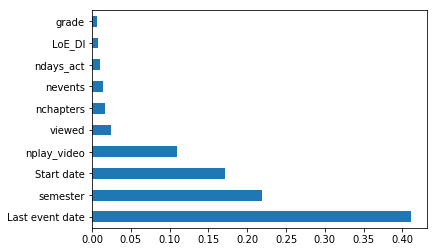

In [27]:
#Feature Importance

#Feature importance gives you a score for each feature of your data.
#The higher the score more important or relevant is the feature towards your output variable.

model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

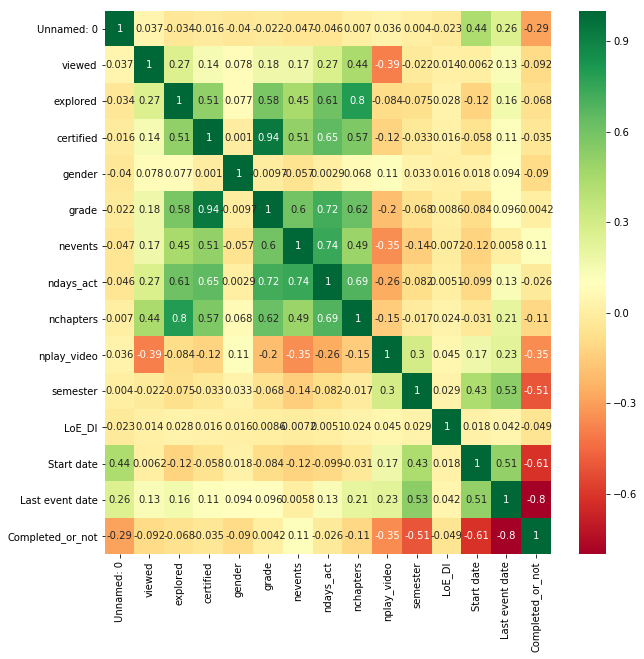

In [31]:
#Correlation Matrix with Heatmap
corrmat = X.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#plot heat map
g=sns.heatmap(X[top_corr_features].corr(),annot=True,cmap="RdYlGn")

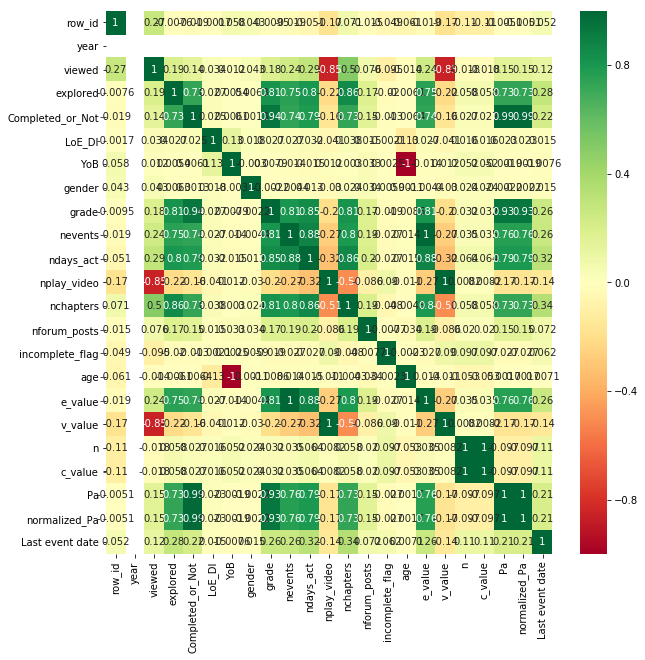

In [28]:
#Correlation Matrix with Heatmap FOR CS_MITX
#Correlation states how the features are related to each other or the target variable.

#get correlations of each features in dataset
corrmat = dataset.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#plot heat map
g=sns.heatmap(dataset[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [30]:
#Clustering for Completed or not in testing dataset CS_MITX
df11=dataset[['viewed','explored','LoE_DI', 'grade', 'nevents', 'ndays_act', 'nchapters','nforum_posts']]

df11=df11.values
kmeans = KMeans(n_clusters=2)
kmeans.fit(df11)
y_km = kmeans.fit_predict(df11)
df7= pd.DataFrame({'certified':y_km})
#df7=df7.values
print("Week ",j+1,"\n",np.array(np.unique(y_km, return_counts=True)).T)
#df=np.concatenate((df,df7),axis=1)
df7.to_csv('Testing result.csv', header=['Completed_or_not'])

Week  4105 
 [[    0 57052]
 [    1  2227]]
